## LVV-T2115: Report

In [1]:
from astropy.time import Time, TimeDelta
import numpy
import pandas as pd
from matplotlib import pylab as plt

from lsst_efd_client import EfdClient

### Process
The process is to interrogate the EFD to see if there are any messages missing over a representative 5 day window of continuous operation.
We will need to connect to the EFD at the summit.  This is done in the next cell.

In [2]:
efd = EfdClient('summit_efd')

Next we select the time window.
Back at the end of May, there was a concerted effort to run the `MTM1M3` subsystem for a contiguous 5 day window.
It turned out that it was able to run essentially uninterrupted for more than 10 days.
There were a number of faults over the course of the window, but those are not a concern here since the message sequence always resets to zero when the system comes back on line.
This means we are just looking for gaps where the messages are not consecutive.

We chose a time close to the beginning of the May run because it overlaps the most intensive use of the system, so should be the most likely to drop messages.
The start of the window is 2021-05-25T00:00:00 and we take all entries for 5 days following that start time.

In [3]:
t1 = Time('2021-05-25T00:00:00', scale='tai')
t2 = t1 + TimeDelta(5*24*3600, format='sec', scale='tai')

The topic chosen is `lsst.sal.MTM1M3.forceActuatorData`.
This is both the highest cadence and one of the widest topics in the `MTM1M3` subsystem.

With both the topic and time window defined, we can now select the data.
We use the "chunked" method since we are retrieving a large amount of data.
This method is more robust for long running queries.

In [4]:
cl = efd.influx_client
query_str = ("SELECT \"private_seqNum\" " +
            "FROM \"efd\".\"autogen\".\"lsst.sal.MTM1M3.forceActuatorData\" " +
            f"WHERE time > '{t1.isot}Z' and time <= '{t2.isot}Z'")

chunks = await cl.query(query_str, chunked=True, chunk_size=2000) # The default chunk size is 1000

seq_chunks = []
offset = 0
async for c in chunks:
    seq_chunks.append(c)
raw_seq_num = pd.concat(seq_chunks)

### Results
Now account for any resets in the system.
It's assumed that the correct offset is the last value of the previous string of messages.

In [5]:
seq_nums = []
offset = 0
for s in raw_seq_num['private_seqNum']:
    if seq_nums and s == 0:
        offset = seq_nums[-1] + 1  # The sequence resets to zero when the system reboots
    seq_nums.append(s + offset)

Check that the array is monotonically increasing.
If it is, the following cell should not print anything.

In [6]:
seq_nums = numpy.array(seq_nums)

last = seq_nums[0]
for s in seq_nums[1:]:
    if not s > last:
        print(s, 'is not greater than', last)
    last = s

Now find the difference between all adjacent entries.
If we have not lost any messages, every entry should be 1.

In [7]:
diff = seq_nums[1:] - seq_nums[:-1]

If all the entries are one, subtracting an array of all ones should produce an array of all zeros.
We show this compactly by demonstrating that subtracting one from every element results in an array that sums to zero.
It is true that this would show the same result if the sum of elements that deviate in the negative direction exactly the same as the sum of the elements that deviate in the positive direction, but we will show a histogram that indicates that this is not the case.

In [8]:
print((diff - numpy.ones(len(diff))).sum())

0.0


In [9]:
hist = numpy.histogram(diff, bins = numpy.array(range(1, 21))/10 - 0.05)

Below is the histogram of the values in the differences between message ID values.
We normalize the value in every bin by the length of the array.
This gives the fraction of the elements in each bin.

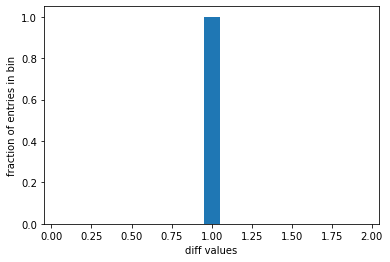

In [10]:
vals = hist[0]/len(diff) # normalize the counts
bins = hist[1][:-1]
bar = plt.bar(bins, vals, width=0.1, align='edge')
xl = plt.xlabel('diff values')
yl = plt.ylabel('fraction of entries in bin')

By printing the values plotted in the histogram above, we show that the bin containing the value of 1 is itself 1.
This means that 100% of the elements in the pairwise difference array are 1.
This means that the message id values are not only monotonically increasing, but also exactly sequential.
Because there are no gaps in the sequence, we infer that we have missed no messages in the stream.

In [11]:
print(vals)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [12]:
len(diff)

21373507